# Automatic instance mask annotations generation using Segment Anything Model

[![Jupyter Notebook](https://img.shields.io/badge/jupyter-%23FA0F00.svg?style=for-the-badge&logo=jupyter&logoColor=white)](https://github.com/openvinotoolkit/datumaro/blob/develop/notebooks/19_automatic_instance_mask_gen_using_sam.ipynb)

This tutorial covers how to generate instance maks annotations automatically using [Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything).
This feature requires a dedicated model inference server instance.
We provide how to build the Docker image of model inference server for SAM in [this guide](https://github.com/openvinotoolkit/datumaro/blob/develop/docker/segment-anything/README.md).
Please build the Docker image first before you follow this tutorial.
We will use the `vit_b` SAM model deployed on [OpenVINO™ Model Server](https://github.com/openvinotoolkit/model_server) instance, thus you need to build `segment-anything-ovms:vit_b` Docker image in preperation.
However, the other SAM model types (`vit_l` and `vit_h`) are avaialbe as well.

## Prerequisite
### Download a sample image
Before starting this tutorial, please download the following sample image. We will generate instance mask annotations for this image.

```bash
curl -O https://raw.githubusercontent.com/openvinotoolkit/datumaro/develop/docker/segment-anything/images/intel_rnb.jpg
```
![sample image](https://raw.githubusercontent.com/openvinotoolkit/datumaro/develop/docker/segment-anything/images/intel_rnb.jpg)

### Launch the Model Inference Server for SAM
In this tutorial, we will launch an instance of the OpenVINO™ Model Server to serve the SAM encoder and decoder models on your local machine.
Alternatively, you can opt for the NVIDIA Triton™ Inference Server as well.
For additional information, please refer to [this guide](https://github.com/openvinotoolkit/datumaro/blob/develop/docker/segment-anything/README.md).

To launch the OpenVINO™ Model Server instance and expose the gRPC endpoint on `localhost:8001`, use the following `docker run` command:

In [ ]:
!docker run -d --rm --name ovms_sam -p 8001:8001 segment-anything-ovms:vit_b --port 8001

## Transfrom bounding box to instance mask annotations

We first create a dataset from the sample image you download.
You can see that there is one dataset item in the dataset, which has an id as `img`.

In [3]:
# Copyright (C) 2023 Intel Corporation
#
# SPDX-License-Identifier: MIT

import datumaro as dm

item_id = "img"
items = [
    dm.DatasetItem(
        id=item_id,
        media=dm.Image.from_file("intel_rnb.jpg"),
        annotations=[],
    )
]

dataset = dm.Dataset.from_iterable(items)
dataset

Dataset
	size=1
	source_path=None
	media_type=<class 'datumaro.components.media.Image'>
	annotated_items_count=0
	annotations_count=0
subsets
	default: # of items=1, # of annotated items=0, # of annotations=0, annotation types=[]
infos
	categories
	

As we can see, there is no annotation in the dataset item.

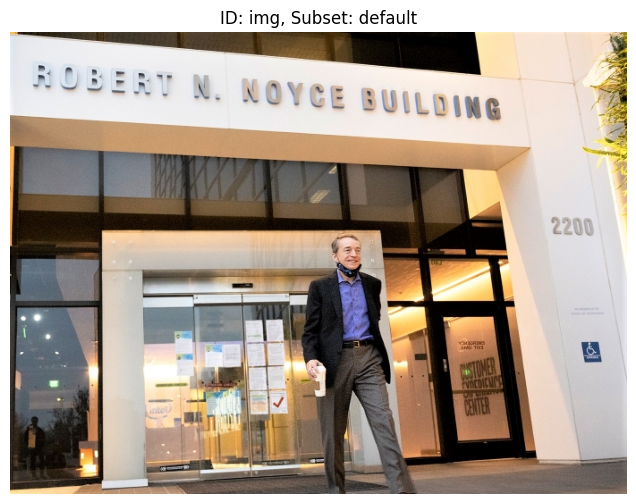

In [4]:
item_id = "img"
subset = dm.DEFAULT_SUBSET_NAME

viz = dm.Visualizer(dataset, figsize=(8, 6))
fig = viz.vis_one_sample(item_id, subset)
fig.show()

Now, we apply `SAMAutomaticMaskGeneration` to the dataset. This transform requires several arguments to execute properly.

`inference_server_type` represents the type of inference server on which SAM encoder and decoder are deployed. In this example, we launched the OpenVINO™ Model Server instance. Therefore, please select `InferenceServerType.ovms`.

The gRPC endpoint address was `localhost:8001`. To configure this, provide the following parameters:
- `host="localhost"`
- `port=8001`
- `protocol_type=ProtocolType.grpc`

You can also specify a `timeout=60.0` value, which represents the maximum seconds to wait for a response from the server instance.

Lastly, we've set `num_workers=0`. This means we will use synchronous iteration to send a model inference request to the server instance and wait for the inference results. If you need to handle multiple inference requests concurrently, you can increase this value to utilize a thread pool. This is particularly useful when dealing with server instances that have high throughput.

In [8]:
from datumaro.plugins.sam_transforms import SAMAutomaticMaskGeneration
from datumaro.plugins.inference_server_plugin import InferenceServerType, ProtocolType

with dm.eager_mode():
    dataset.transform(
        SAMAutomaticMaskGeneration,
        inference_server_type=InferenceServerType.ovms,
        host="localhost",
        port=8001,
        timeout=60.0,
        protocol_type=ProtocolType.grpc,
        num_workers=0,
        points_per_side=16,
    )

Let's visualize the transformed dataset again.
In the following figure, you can see that many instance mask annotations are generated.

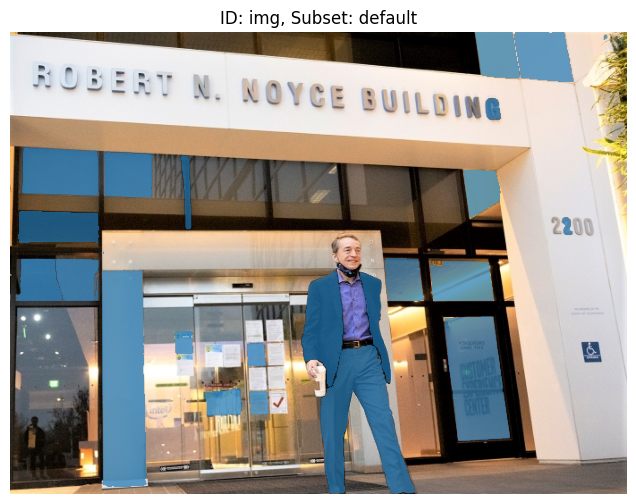

In [9]:
viz = dm.Visualizer(dataset, figsize=(8, 6), alpha=0.7)
fig = viz.vis_one_sample(item_id, subset)
fig.show()

Let's explore some important parameters used in this feature.

This transformation includes a post-processing step designed to enhance the quality of the generated instance masks. 
You have the flexibility to adjust several parameters for this post-processing step:

- `points_per_side` (int): The number of points to be sampled
    along one side of the image. The total number of points is
    points_per_side**2 on a uniform 2d grid.
- `points_per_batch` (int): Sets the number of points run simultaneously
    by the model. Higher numbers may be faster but use more GPU memory.
- `pred_iou_thresh` (float): A filtering threshold in [0,1], using the
    model's predicted mask quality.
- `stability_score_thresh` (float): A filtering threshold in [0,1], using
    the stability of the mask under changes to the cutoff used to binarize
    the model's mask predictions.
- `stability_score_offset` (float): The amount to shift the cutoff when
    calculated the stability score.
- `box_nms_thresh` (float): The box IoU cutoff used by non-maximal
    suppression to filter duplicate masks.
- `min_mask_region_area` (int): If >0, postprocessing will be applied
    to remove the binary mask which has the number of 1s less than min_mask_region_area.

This time we increase the `points_per_side` value to create instance masks more densely.

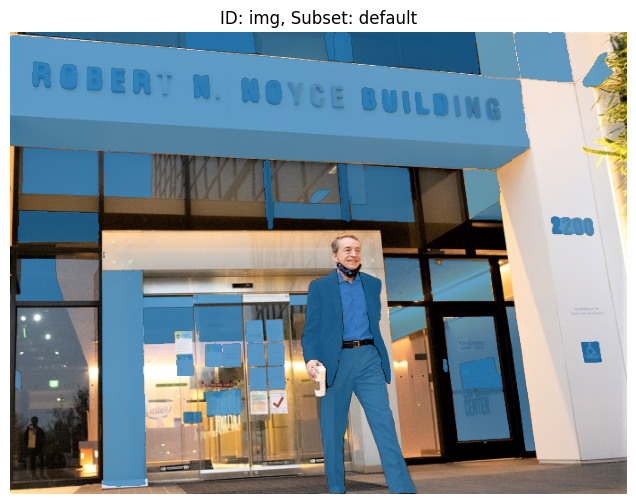

In [11]:
with dm.eager_mode():
    dataset.transform(
        SAMAutomaticMaskGeneration,
        inference_server_type=InferenceServerType.ovms,
        host="localhost",
        port=8001,
        timeout=60.0,
        protocol_type=ProtocolType.grpc,
        num_workers=0,
        points_per_side=32,
    )

viz = dm.Visualizer(dataset, figsize=(8, 6), alpha=0.7)
fig = viz.vis_one_sample(item_id, subset)
fig.show()

To produce masks only for the large enough instances, we can set the `min_mask_region_area` value to `2500` as follows.

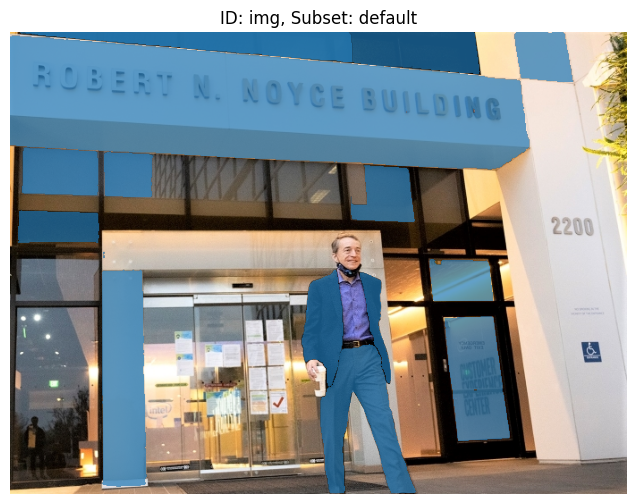

In [14]:
with dm.eager_mode():
    dataset.transform(
        SAMAutomaticMaskGeneration,
        inference_server_type=InferenceServerType.ovms,
        host="localhost",
        port=8001,
        timeout=60.0,
        protocol_type=ProtocolType.grpc,
        num_workers=0,
        points_per_side=32,
        min_mask_region_area=2500,
    )

viz = dm.Visualizer(dataset, figsize=(8, 6), alpha=0.7)
fig = viz.vis_one_sample(item_id, subset)
fig.show()